# GAN Denoising on FER2013 emotions dataset

In this notebook we implement a Generative Adversary Network for task of denoising images, taken from FER2013 dataset.

### Installing the required libraries:

In [1]:
!pip install numpy pandas torch torchvision torchmetrics matplotlib mplcyberpunk

## Loading the prerequisites:

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import TensorDataset as Dataset
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from PIL import Image
from tqdm import tqdm
import os
import time
import gc
import mplcyberpunk
plt.style.use('cyberpunk')
device = "cuda:1" if torch.cuda.is_available() else "cpu"

## Data extraction and processing:

You can download the dataset from this: https://drive.google.com/file/d/1k2A7dJgQ25-Tqzmda49kJElo-1vhbEQk/view?usp=sharing

And place it where the next cell can find it!


In [4]:
df = pd.read_csv("fer2013.csv")
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
def str_to_arr(x):
    x = x.split(" ")
    return [int(i) for i in x]

df["pixels"] = df["pixels"].apply(lambda x: str_to_arr(x))
df

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training
...,...,...,...
35882,6,"[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...",PrivateTest
35883,3,"[178, 174, 172, 173, 181, 188, 191, 194, 196, ...",PrivateTest
35884,0,"[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...",PrivateTest
35885,3,"[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...",PrivateTest


## Visualizing a sample:

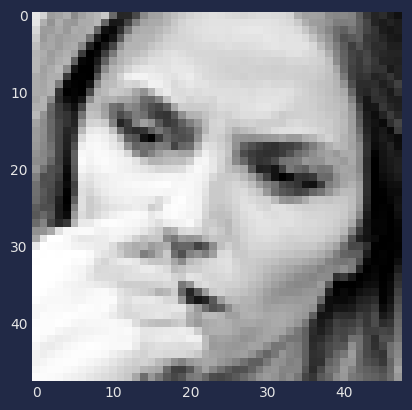

In [6]:
index = 2
img = np.array(df["pixels"].loc[index]).reshape(48,48)
plt.grid(False)
plt.imshow(img, cmap="gray")
plt.show()

## Adding Gaussian noise:

In [7]:
def add_gaussian_noise(pixels, mean=0, std=10):
    noise = np.random.normal(mean, std, len(pixels))
    noisy_pixels = np.clip(pixels + noise, 0, 255).astype(np.uint8)
    return noisy_pixels

df['noisy'] = df['pixels'].apply(lambda x: add_gaussian_noise(np.array(x), mean=2, std=15))
df

,emotion,pixels,Usage,noisy
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training,"[55, 83, 80, 79, 57, 48, 78, 84, 80, 65, 43, 5..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training,"[153, 142, 146, 142, 162, 126, 106, 147, 183, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training,"[204, 206, 161, 140, 182, 156, 121, 183, 201, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training,"[46, 25, 19, 26, 12, 31, 34, 10, 53, 43, 35, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training,"[22, 12, 7, 5, 24, 6, 0, 3, 3, 0, 0, 17, 26, 0..."
...,...,...,...,...
35882,6,"[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...",PrivateTest,"[60, 18, 29, 25, 37, 26, 60, 46, 17, 57, 34, 4..."
35883,3,"[178, 174, 172, 173, 181, 188, 191, 194, 196, ...",PrivateTest,"[167, 152, 186, 154, 163, 191, 178, 225, 176, ..."
35884,0,"[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...",PrivateTest,"[23, 12, 24, 1, 30, 0, 20, 41, 32, 25, 21, 30,..."
35885,3,"[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...",PrivateTest,"[23, 35, 56, 48, 40, 3, 49, 72, 58, 68, 89, 34..."


## Visualizing noisy image:

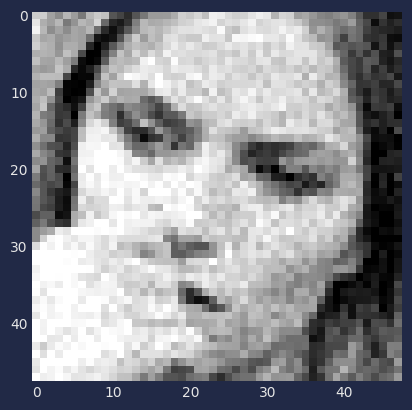

In [8]:
img = np.array(df["noisy"].loc[index]).reshape(48,48)
plt.grid(False)
plt.imshow(img, cmap="gray")
plt.show()

## Defining Dataset for better data management:

In [9]:
class ImageDataset(Dataset):
    def __init__(self, images, noises, device):
        self.images = images
        self.noises = noises
        self.device = device

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images.iloc[idx], dtype=torch.float32).reshape(1, 48, 48).to(self.device)
        noise = torch.tensor(self.noises.iloc[idx], dtype=torch.float32).reshape(1, 48, 48).to(self.device)
        return image, noise


In [10]:
train_set = df[df["Usage"] == "Training"][["pixels", "noisy"]]
test_set = df[df["Usage"] == "PrivateTest"][["pixels", "noisy"]]
val_set = df[df["Usage"] == "PublicTest"][["pixels", "noisy"]]
train_set

,pixels,noisy
0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...","[55, 83, 80, 79, 57, 48, 78, 84, 80, 65, 43, 5..."
1,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...","[153, 142, 146, 142, 162, 126, 106, 147, 183, ..."
2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...","[204, 206, 161, 140, 182, 156, 121, 183, 201, ..."
3,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...","[46, 25, 19, 26, 12, 31, 34, 10, 53, 43, 35, 2..."
4,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...","[22, 12, 7, 5, 24, 6, 0, 3, 3, 0, 0, 17, 26, 0..."
...,...,...
28704,"[84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 8...","[84, 85, 125, 80, 81, 83, 102, 91, 81, 90, 114..."
28705,"[114, 112, 113, 113, 111, 111, 112, 113, 115, ...","[107, 105, 113, 90, 108, 108, 134, 114, 98, 11..."
28706,"[74, 81, 87, 89, 95, 100, 98, 93, 105, 120, 12...","[86, 88, 71, 104, 95, 118, 92, 106, 88, 119, 1..."
28707,"[222, 227, 203, 90, 86, 90, 84, 77, 94, 87, 99...","[196, 221, 193, 119, 82, 97, 104, 84, 100, 109..."


## Creating dataloaders for loading efficiently:

In [12]:
train_dataset = ImageDataset(train_set["pixels"], train_set["noisy"], device="cuda:1")
test_dataset = ImageDataset(test_set["pixels"], test_set["noisy"], device="cuda:1")
val_dataset = ImageDataset(val_set["pixels"], val_set["noisy"], device="cuda:1")

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=16,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=16,
                                         shuffle=True)

# Model Definition:

In [33]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, padding=padding),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(out_channels, out_channels, size, padding=padding, stride=stride),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        
        x = self.convs(x)
        return x


class DeConv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2):
        super().__init__()
        self.deConv = nn.ConvTranspose2d(in_channels, out_channels, size,
                                         padding=1, stride=2, output_padding=1)
        self.convs = Conv_block(out_channels * 2, out_channels, size, padding, dropout)

    def forward(self, x, residual):
        
        x = self.deConv(x)
        x = torch.cat([x, residual], 1)
        x = self.convs(x)
        return x

In [40]:
class GeneratorUnet(nn.Module):
    
    def __init__(self, d=64, out_channels=1, dropout=0.2):
        super().__init__()

        self.conv_blocks = nn.ModuleList([
            Conv_block(1, d, dropout=dropout),
            Conv_block(d, 2 * d, stride=2, dropout=dropout),
            Conv_block(2 * d, 4 * d, stride=2, dropout=dropout),
            Conv_block(4 * d, 8 * d, stride=2, dropout=dropout),
            Conv_block(8 * d, 16 * d, stride=2, dropout=dropout)
        ])

        self.deConv_blocks = nn.ModuleList([
            DeConv_block(16 * d, 8 * d, dropout=dropout),
            DeConv_block(8 * d, 4 * d, dropout=dropout),
            DeConv_block(4 * d, 2 * d, dropout=dropout),
            DeConv_block(2 * d, d, dropout=dropout),
        ])

        self.output_conv = nn.Conv2d(d, out_channels, 3, padding=1)

    def forward(self, x):
        x1 = self.conv_blocks[0](x)
        x2 = self.conv_blocks[1](x1)
        x3 = self.conv_blocks[2](x2)
        x4 = self.conv_blocks[3](x3)
        x5 = self.conv_blocks[4](x4)

        x = self.deConv_blocks[0](x5, x4)
        x = self.deConv_blocks[1](x, x3)
        x = self.deConv_blocks[2](x, x2)
        x = self.deConv_blocks[3](x, x1)

        x = self.output_conv(x)

        return x

In [41]:
class Discriminator(nn.Module):
    
    def __init__(self, label_channels=1, input_channels=1, d=64):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(label_channels + input_channels, d, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d),

            nn.Conv2d(d, d*2, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*2),

            nn.Conv2d(d*2, d*4, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*4),

            nn.Conv2d(d*4, d*8, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*8),

            nn.Conv2d(d*8, 1, 3, 2, 1),
        )
        self.float()

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.convs(x)

        return x

In [42]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [89]:
generator = GeneratorUnet()
discriminator = Discriminator()
model = nn.ModuleDict({'generator': generator, 'discriminator': discriminator})

In [90]:
generator_l2_loss = nn.MSELoss()
generator_gan_loss = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss().to(device)
discriminator_gan_loss = nn.BCEWithLogitsLoss()

generator_optimizer = Adam(generator.parameters(), lr=0.0001)
discriminator_optimizer = Adam(discriminator.parameters(), lr=0.0001)

# Training loop:

In [91]:
epoch = 20
lam = 100

early_stopping = EarlyStopping(patience=5, delta=0.01)
model.to(device)
history = {'train': [], 'valid': []}

for i in range(epoch):
    print(f'Epoch {i+1} ...')
    model.train()
    sum_train_mse = 0
    training_steps = 0

    for (img, noise) in tqdm(train_loader):
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()

        img = img.to(device)
        noise = noise.to(device)

        # Train discriminator
        D_result_real = model['discriminator'](noise, img).squeeze().float()
        D_real_loss = discriminator_gan_loss(D_result_real, torch.ones(D_result_real.size(), device=device))

        with torch.no_grad():
            G_result = model['generator'](noise).float()
        D_result_fake = model['discriminator'](noise, G_result).squeeze().float()
        D_fake_loss = discriminator_gan_loss(D_result_fake, torch.zeros(D_result_fake.size(), device=device))
        D_train_loss = (D_real_loss + D_fake_loss) * 0.5

        D_train_loss.backward()
        discriminator_optimizer.step()

        # Train generator
        G_result = model['generator'](noise).float()
        D_result_fake = model['discriminator'](noise, G_result).squeeze().float()
        G_gan_loss = generator_gan_loss(D_result_fake, torch.ones(D_result_fake.size(), device=device))
        G_mse_loss = generator_l2_loss(G_result, img)
        G_train_loss = G_gan_loss + G_mse_loss * lam

        G_train_loss.backward()
        generator_optimizer.step()

        sum_train_mse += G_mse_loss.cpu().item()
        training_steps += 1

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for (img, noise) in tqdm(val_loader):
        img = img.to(device)
        noise = noise.to(device)
        with torch.no_grad():
            output = model['generator'](noise)
        loss = criterion(output, img)
        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    early_stopping(sum_valid_mse / valid_steps, model['generator'])
    if early_stopping.early_stop:
        print("Early stopping")
        break
            
    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1} | Average Train MSE: {sum_train_mse / training_steps},',
          f' | Average Validation MSE: {sum_valid_mse / valid_steps}')


Epoch 1 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 250.45it/s]


Epoch 1 | Average Train MSE: 15379.113548376567,  | Average Validation MSE: 10504.13595486111
Epoch 2 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 250.30it/s]


Epoch 2 | Average Train MSE: 5662.74184801532,  | Average Validation MSE: 2092.653342013889
Epoch 3 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 252.59it/s]


Epoch 3 | Average Train MSE: 771.4865097853467,  | Average Validation MSE: 113.82383073594835
Epoch 4 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 249.90it/s]


Epoch 4 | Average Train MSE: 234.07378477133747,  | Average Validation MSE: 85.41791052924262
Epoch 5 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 250.54it/s]


Epoch 5 | Average Train MSE: 204.81141827936625,  | Average Validation MSE: 86.3906010945638
Epoch 6 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 250.64it/s]


Epoch 6 | Average Train MSE: 180.7760383712216,  | Average Validation MSE: 80.65851172553168
Epoch 7 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 251.42it/s]


Epoch 7 | Average Train MSE: 159.55380805820477,  | Average Validation MSE: 93.51810153537326
Epoch 8 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 237.55it/s]


Epoch 8 | Average Train MSE: 144.24363391419308,  | Average Validation MSE: 79.74438218858506
Epoch 9 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 252.74it/s]


Epoch 9 | Average Train MSE: 136.0456792209806,  | Average Validation MSE: 81.56447323269315
Epoch 10 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 252.46it/s]


Epoch 10 | Average Train MSE: 130.65946488234326,  | Average Validation MSE: 102.10233459472656
Epoch 11 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 251.12it/s]


Epoch 11 | Average Train MSE: 126.76906930822516,  | Average Validation MSE: 76.40114474826389
Epoch 12 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 249.99it/s]


Epoch 12 | Average Train MSE: 123.41715888658274,  | Average Validation MSE: 73.96195995754665
Epoch 13 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 253.33it/s]


Epoch 13 | Average Train MSE: 119.01237210669558,  | Average Validation MSE: 70.27843380398221
Epoch 14 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 249.68it/s]


Epoch 14 | Average Train MSE: 117.73632054660978,  | Average Validation MSE: 67.45751998901368
Epoch 15 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 250.97it/s]


Epoch 15 | Average Train MSE: 113.70185283352738,  | Average Validation MSE: 75.26327996148004
Epoch 16 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 250.72it/s]


Epoch 16 | Average Train MSE: 110.33569794126208,  | Average Validation MSE: 76.58416093614366
Epoch 17 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 249.64it/s]


Epoch 17 | Average Train MSE: 108.77831091070574,  | Average Validation MSE: 75.11692526923285
Epoch 18 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 251.11it/s]


Epoch 18 | Average Train MSE: 107.25330448416283,  | Average Validation MSE: 73.21764880710178
Epoch 19 ...


100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 250.70it/s]

Early stopping


## Loading the best model (with least val loss)

In [95]:
early_stopping.load_best_model(model['generator'])

## Visualizing a denoised sample:

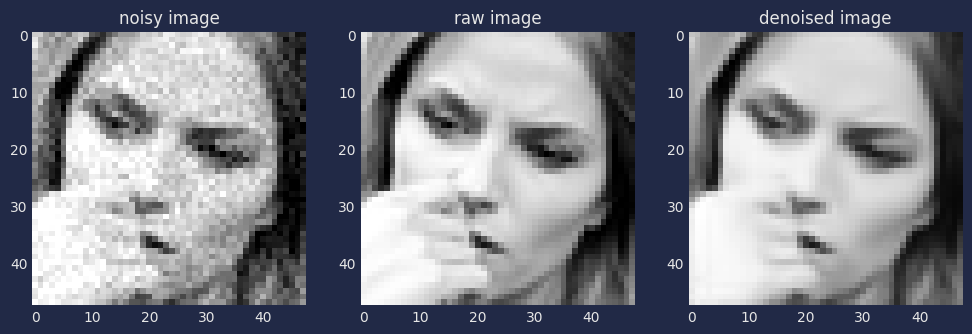

In [99]:
index = 2
img = torch.tensor(df["pixels"].loc[index]).reshape(48,48).to(device)
noisy_img = torch.tensor(df["noisy"].loc[index]).reshape(48,48).to(device)

model.to(device)
model.eval()
input_tensor = noisy_img.reshape(1,1,48,48).type(torch.float32)
denoised = model['generator'](input_tensor)

plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.title("noisy image")
plt.imshow(noisy_img.cpu().detach().numpy(), cmap='gray')
plt.grid(False)

plt.subplot(1,3,2)
plt.title("raw image")
plt.imshow(img.cpu().detach().numpy(), cmap='gray')
plt.grid(False)

plt.subplot(1,3,3)
plt.title("denoised image")
plt.imshow(denoised.cpu().squeeze().detach().numpy(), cmap='gray')
plt.grid(False)

# Loss for the test set:

In [100]:
test_loss = 0
for (img, noise) in tqdm(test_loader):
        img = img.to(device)
        noise = noise.to(device)
        with torch.no_grad():
            output = model['generator'](noise)
        loss = criterion(output, img)
        test_loss += loss.cpu().item()

test_loss /= len(test_loader)
print(f"MSE Loss on the Test set: {test_loss}")

100%|██████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 248.51it/s]

MSE Loss on the Test set: 76.26278376261394
